## Task 1: Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
print(customers.isnull().sum())

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64


In [4]:
print(products.isnull().sum())

ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64


In [5]:
print(transactions.isnull().sum())

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [6]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None


In [7]:
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None


In [8]:
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None


In [9]:
transactions_with_customer = pd.merge(transactions, customers, on='CustomerID', how='left')
transactions_with_product = pd.merge(transactions_with_customer, products, on='ProductID', how='left')

C:\Users\prash\AppData\Local\Temp\ipykernel_25028\2517340618.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x='Region', palette='Set2')


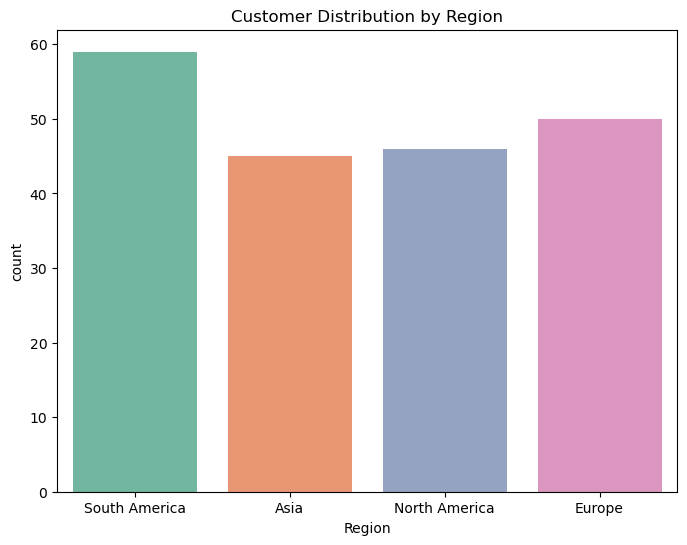

In [10]:
plt.figure(figsize=(8,6))
sns.countplot(data=customers, x='Region', palette='Set2')
plt.title('Customer Distribution by Region')
plt.show()

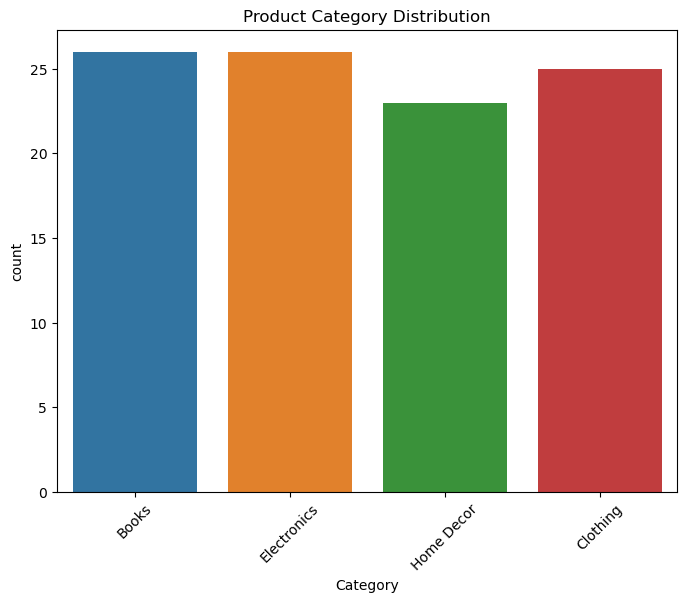

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(data=products, x='Category', hue='Category') 
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

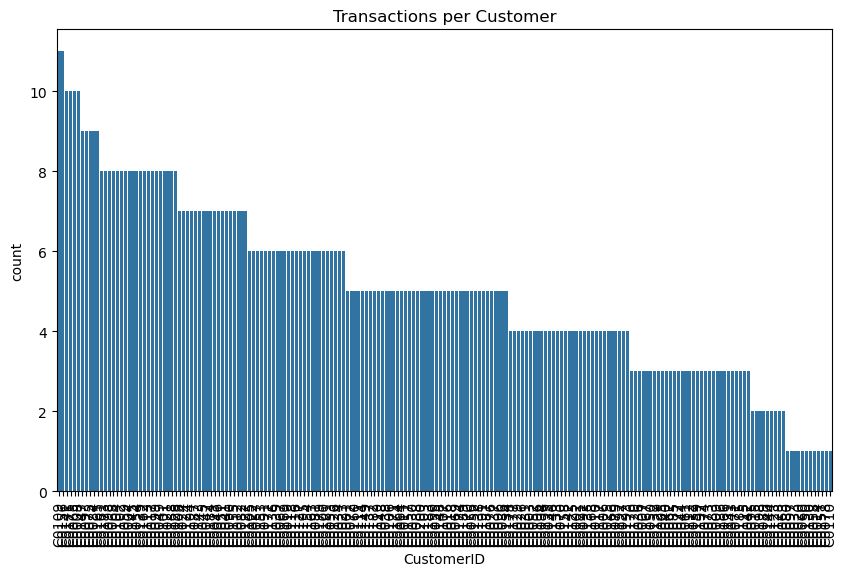

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(data=transactions_with_customer, x='CustomerID', order=transactions_with_customer['CustomerID'].value_counts().index)
plt.title('Transactions per Customer')
plt.xticks(rotation=90)
plt.show()

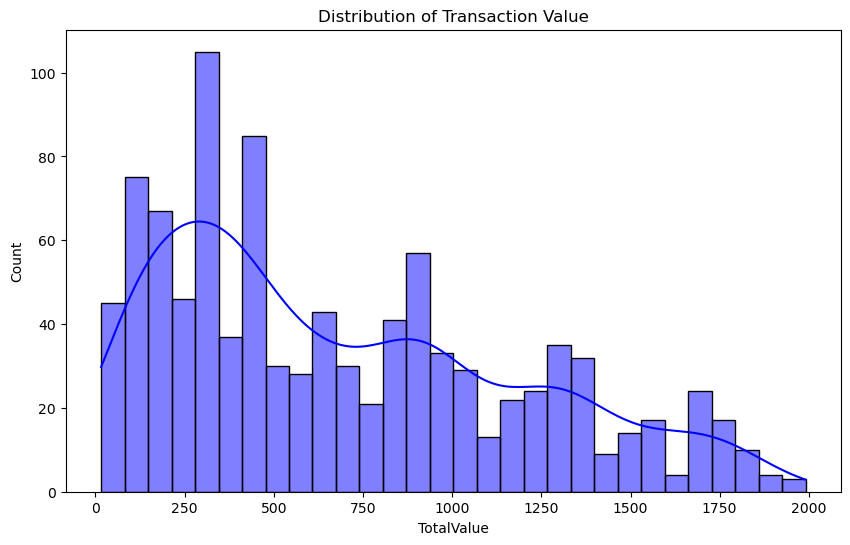

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(transactions_with_customer['TotalValue'], kde=True, bins=30, color='blue')
plt.title('Distribution of Transaction Value')
plt.show()

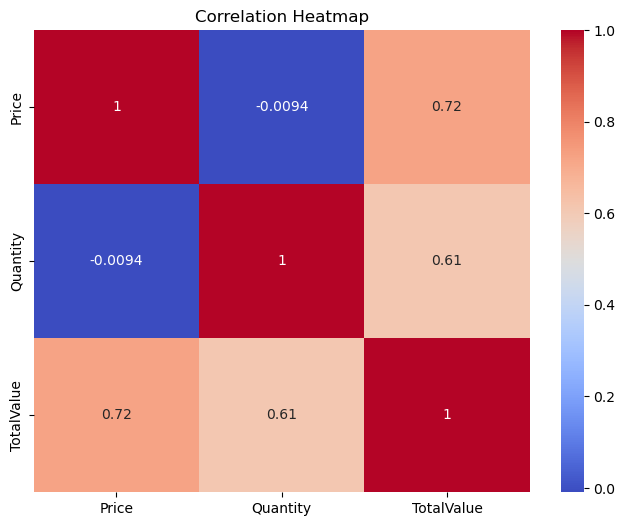

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(transactions_with_customer[['Price', 'Quantity', 'TotalValue']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Task 2: Lookalike Model

In [22]:
# Prepare features for similarity calculation
customer_transactions = transactions_with_customer.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'Price': 'mean'      # Average price per transaction
}).reset_index()

In [23]:
# Merge with customer profiles
customer_profiles = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

In [54]:
# Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
customer_profiles[['TotalValue', 'Quantity', 'Price']] = scaler.fit_transform(customer_profiles[['TotalValue', 'Quantity', 'Price']])


In [38]:
# Cosine similarity calculation
similarity_matrix = cosine_similarity(customer_profiles[['TotalValue', 'Quantity', 'Price']])

In [39]:
# Finding top 3 lookalikes for the first 20 customers
lookalikes = {}

for idx in range(20):  # First 20 customers
    similarity_scores = similarity_matrix[idx]
    sorted_similarities = np.argsort(similarity_scores)[::-1][1:4]  # Top 3 excluding self
    similar_customers = [(customer_profiles.iloc[i]['CustomerID'], similarity_scores[i]) for i in sorted_similarities]
    lookalikes[customer_profiles.iloc[idx]['CustomerID']] = similar_customers

In [40]:
lookalike_data = []
for customer_id, similar_customers in lookalikes.items():
    for lookalike_customer, similarity_score in similar_customers:
        lookalike_data.append([customer_id, lookalike_customer, similarity_score])

In [41]:
lookalike_df = pd.DataFrame(lookalike_data, columns=['CustomerID', 'LookalikeCustomerID', 'SimilarityScore'])

In [42]:
# Save the result to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

In [43]:
print(lookalike_df.head())

  CustomerID LookalikeCustomerID  SimilarityScore
0      C0001               C0103         0.997573
1      C0001               C0092         0.996879
2      C0001               C0135         0.992736
3      C0002               C0029         0.999854
4      C0002               C0077         0.996104


## Task 3: Customer Segmentation / Clustering

In [44]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [45]:
# Prepare the customer data (combine profile and transaction data)
customer_data = pd.merge(customer_profiles[['CustomerID', 'Region', 'TotalValue', 'Quantity', 'Price']], 
                         transactions_with_customer[['CustomerID', 'TotalValue']], 
                         on='CustomerID', 
                         how='left')

In [48]:
# Drop the unnecessary 'TotalValue_y' column and keep 'TotalValue_x'
customer_data = customer_data.drop(columns=['TotalValue_y'])

# Rename 'TotalValue_x' to 'TotalValue' for clarity
customer_data = customer_data.rename(columns={'TotalValue_x': 'TotalValue'})

# Verify the columns again
print(customer_data.columns)



Index(['CustomerID', 'Region', 'TotalValue', 'Quantity', 'Price'], dtype='object')


In [49]:
# Standardize the data again
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['TotalValue', 'Quantity', 'Price']])

# Optionally, store it back into the dataframe
customer_data[['TotalValue', 'Quantity', 'Price']] = customer_data_scaled


In [51]:
import os
from sklearn.cluster import KMeans

# Set environment variable to limit threads
os.environ["OMP_NUM_THREADS"] = "4"

# Assuming customer_data_scaled is already prepared
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose number of clusters (between 2 and 10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Print cluster assignments
print(customer_data[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        3
1      C0001        3
2      C0001        3
3      C0001        3
4      C0001        3


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [52]:
# Calculate DB Index
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
print(f"DB Index: {db_index}")

DB Index: 1.0909551184425192


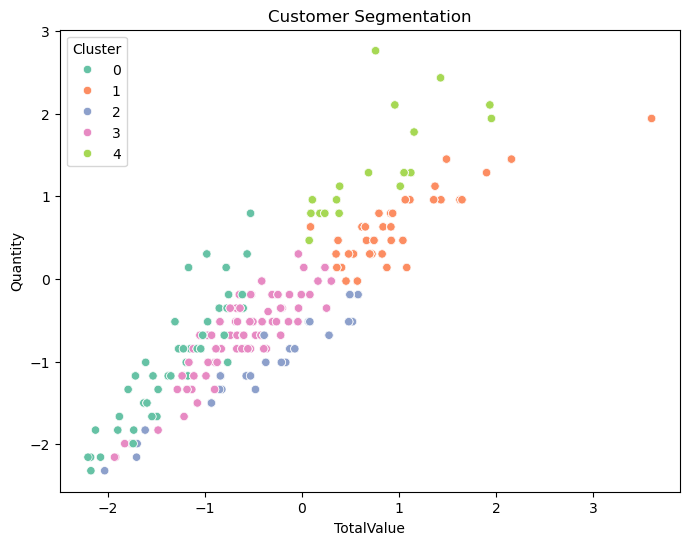

In [53]:
# Visualize the clusters (use PCA for dimensionality reduction if needed)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_data['TotalValue'], y=customer_data['Quantity'], hue=customer_data['Cluster'], palette='Set2')
plt.title('Customer Segmentation')
plt.show()
